In [184]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# build vocabulary of characters and mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [316]:
# build dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:

        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [317]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182441, 3]), torch.int64, torch.Size([182441]), torch.int64)

In [335]:
C = torch.randn([27, 10]) # embedding table
 
W1 = torch.randn((30, 200)) # 6 -> 3 embeddings, each 2 dimensions.
b1 = torch.randn(200)
W2 = torch.randn((200, 27)) # output layer (logits)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [336]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [337]:
for p in parameters:
    p.requires_grad = True

In [338]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [339]:
lri = []
lossi = []
stepi = []

In [355]:
for i in range(100000):
    
    # minibatch construct (optimize 32 examples at a time)
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # FORWARD PASS
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item()) # this is the loss for only this minibatch

2.1340763568878174


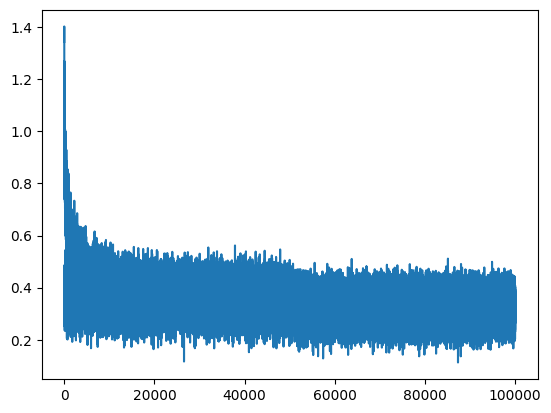

In [347]:
plt.plot(stepi, lossi)

In [356]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0874, grad_fn=<NllLossBackward0>)

In [357]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1384, grad_fn=<NllLossBackward0>)

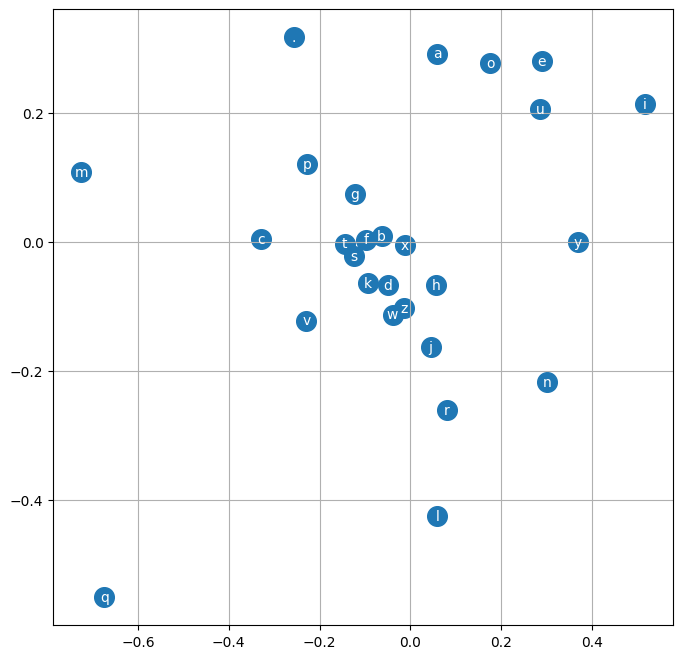

In [221]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [362]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

moha.
kayah.
keel.
ndhoyal.
reisha.
eks.
leg.
adered.
elin.
shi.
jen.
eden.
camanar.
kayzion.
kamin.
shub.
ridhi.
jest.
jair.
jelionnie.


1) Minibatching: works because thought it computes less reliable gradients it is fast to train because of small number of examples, so we can run more iterations and reduce loss much quicker. Expect some variance in loss, i.e. it won't monotonically decrease.

2) Finding a good learning rate: find a 'good' range where loss is not exploding or not going down. Experiment with learning rates in this range, i.e. using torch.linspace, by using this in minibatch optimization. Track learning rate and corresponding loss and plot this. A good learning rate will typically be in the 'valley' where loss is low and stable.

3) Train/val/test splitting: 80%, 10%, 10% -> train parameters, hyperparameters (layer sizes, learning rate, regularization, etc.), keep test split small to avoid overfitting to the test data. If losses between train and dev are similar, then model might be underfitting, consider increasing model size. In production, you are looking for the best dev set performance, experiment with hyperparameters.